In [1]:
from pytorch__autoencoder import Autoencoder, ConvAutoencoder, DenoisingAutoencoder
from tqdm import trange
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# ==================== Load Mnist ==================== #

batch_size = 64

train_dataset = datasets.MNIST(root='./', download=True, train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./', download=True, train=False, transform=transforms.ToTensor())

x_train = train_dataset.data.float()
y_train = train_dataset.targets
y_train_ohe = torch.nn.functional.one_hot(y_train)

train_dl = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)


-----------
### Autoencoder with linear layers

In [5]:
# ==================== Define the model ==================== #

max_epochs = 5
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

Training loss: 0.0162: 100%|██████████████████████████████████████████| 5/5 [00:42<00:00,  8.57s/it]


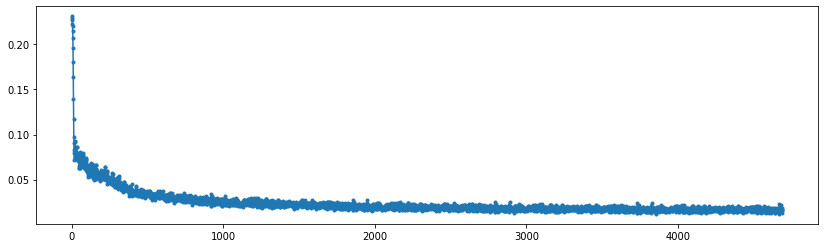

In [6]:
# ==================== Train the model ==================== #

training_losses = []
for epoch in (t := trange(max_epochs, ncols=100)):
    for batch, (images, labels) in enumerate(train_dl):
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        reconstructions = model(images)

        model.zero_grad()
        loss = criterion(reconstructions, images)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())
        t.set_description(f'Training loss: {loss.item():.4f}')
plt.figure(figsize=(14, 4))
plt.plot(training_losses, '.-')
plt.show()

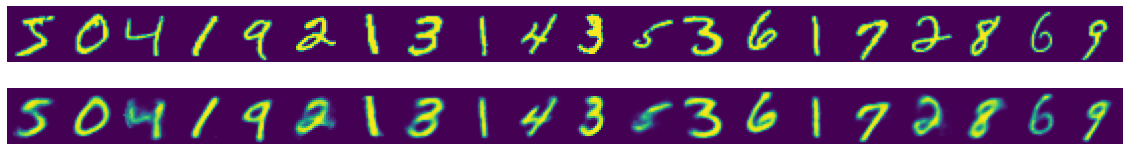

In [7]:
# ==================== Check reconstructions ==================== #

model = model.to('cpu')

batch_index = 0
number_of_images = 20
images = next(iter(train_dl))[batch_index][0:number_of_images]

fig, axis = plt.subplots(2, number_of_images, figsize=(20, 3))
for index, image in enumerate(images):
    axis[0, index].imshow(image.permute(1, 2, 0))
    axis[0, index].set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)

with torch.no_grad():
    images = next(iter(train_dl))[0][0:number_of_images]
    for index, img in enumerate(images):
        reconstruction = model(img.reshape(-1, 28 * 28))
        axis[1, index].imshow(reconstruction.reshape(28, 28, 1))
        axis[1, index].set_axis_off()

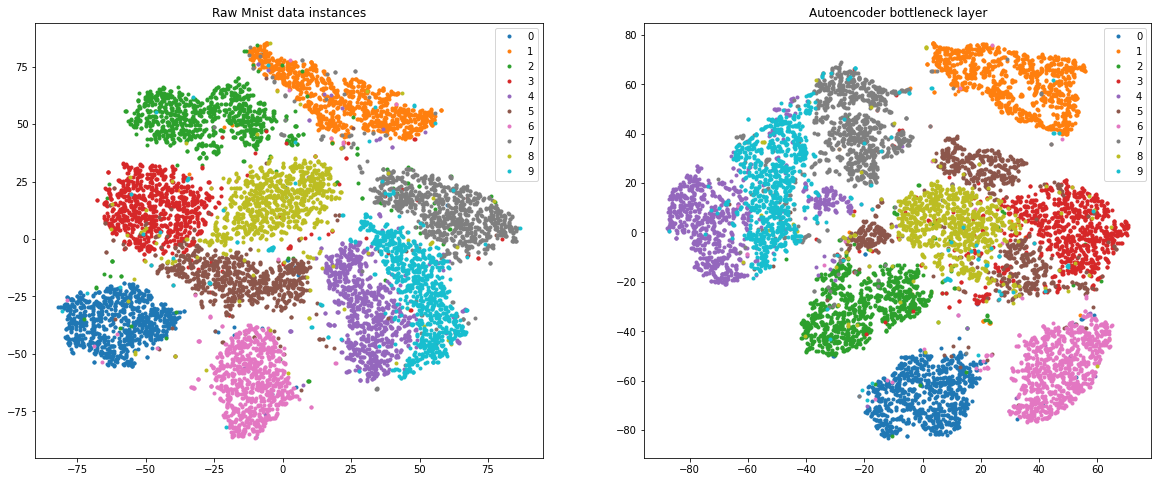

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [8]:
# ==================== T-SNE (with 2 components) on the original dataset (28x28-d) ==================== #

fig, axis = plt.subplots(1, 2, figsize=(20, 8))

tsne = TSNE(n_components=2, )
x_np = test_dl.dataset.data.reshape(-1, 28 * 28).numpy()
y_np = test_dl.dataset.targets.numpy()
x_train_raw = tsne.fit_transform(x_np)

df_raw = pd.DataFrame(np.concatenate((x_train_raw, y_np.reshape(-1, 1)), axis=1))
df_raw.columns = ['comp1', 'comp2', 'number']
groups = df_raw.groupby("number")
fig1 = plt.figure(figsize=(12, 8))
for name, group in groups:
    axis[0].plot(group["comp1"], group["comp2"], marker=".", linestyle="", label=name)
axis[0].set_title('Raw Mnist data instances')
axis[0].legend(range(10))

# ==================== T-SNE (with 2 components) on the AE embedded space (10-d) ==================== #

x_train_embedded = model.encoder(test_dl.dataset.data.reshape(-1, 28 * 28).float()).detach()

x_train_ae = tsne.fit_transform(x_train_embedded)

df_embedded = pd.DataFrame(np.concatenate((x_train_ae, y_np.reshape(-1, 1)), axis=1))
df_embedded.columns = ['comp1', 'comp2', 'number']
groups = df_embedded.groupby("number")
fig2 = plt.figure(figsize=(12, 8))
for name, group in groups:
    axis[1].plot(group["comp1"], group["comp2"], marker=".", linestyle="", label=name)
axis[1].set_title('Autoencoder bottleneck layer')
axis[1].legend(range(10))

-----------
### Autoencoder with Convolutional layers

Training loss: 0.0189: 100%|██████████████████████████████████████████| 5/5 [01:01<00:00, 12.27s/it]


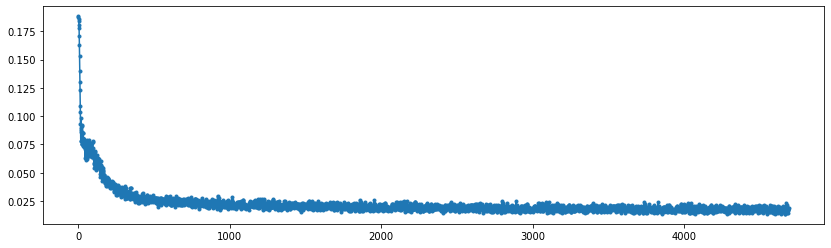

In [9]:
# ==================== Define the model ==================== #

max_epochs = 5
model = ConvAutoencoder(input_channels=1, bottleneck_dimension=10).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# ==================== Training the model ==================== #

training_losses = []
for epoch in (t := trange(max_epochs, ncols=100)):
    for batch, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)

        reconstructions = model(images)

        model.zero_grad()
        loss = criterion(reconstructions, images)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())
        t.set_description(f'Training loss: {loss.item():.4f}')

plt.figure(figsize=(14, 4))
plt.plot(training_losses, '.-')

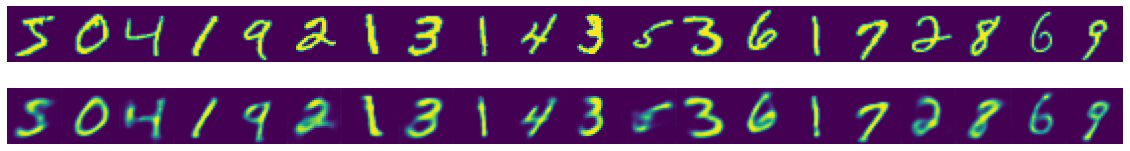

In [10]:
# ==================== Check reconstructions ==================== #

model = model.to('cpu')

batch_index = 0
number_of_images = 20
images = next(iter(train_dl))[batch_index][0:number_of_images]

fig, axis = plt.subplots(2, number_of_images, figsize=(20, 3))
for index, image in enumerate(images):
    axis[0, index].imshow(image.permute(1, 2, 0))
    axis[0, index].set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)

with torch.no_grad():
    images = next(iter(train_dl))[0][0:number_of_images]
    for index, img in enumerate(images):
        reconstruction = model(img.reshape(1, 1, 28, 28))
        axis[1, index].imshow(reconstruction.reshape(28, 28, 1))
        axis[1, index].set_axis_off()

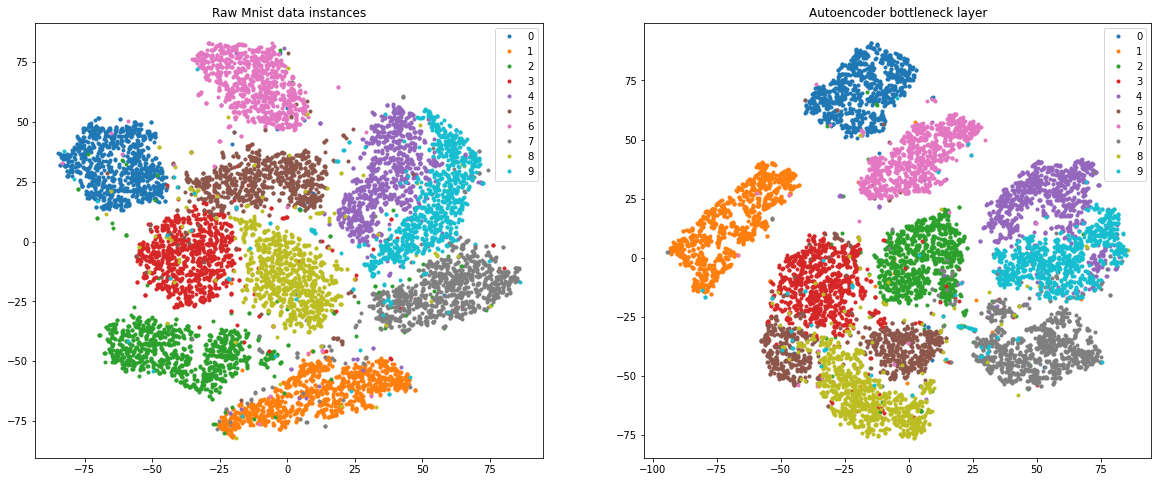

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [11]:
# ==================== T-SNE (with 2 components) on the original dataset (28x28-d) ==================== #

fig, axis = plt.subplots(1, 2, figsize=(20, 8))

tsne = TSNE(n_components=2)
x_np = test_dl.dataset.data.numpy()
y_np = test_dl.dataset.targets.numpy()
x_train_raw = tsne.fit_transform(x_np.reshape(-1, 28 * 28))

df_raw = pd.DataFrame(np.concatenate((x_train_raw, y_np.reshape(-1, 1)), axis=1))
df_raw.columns = ['comp1', 'comp2', 'number']
groups = df_raw.groupby("number")
fig1 = plt.figure(figsize=(12, 8))
for name, group in groups:
    axis[0].plot(group["comp1"], group["comp2"], marker=".", linestyle="", label=name)
axis[0].set_title('Raw Mnist data instances')
axis[0].legend(range(10))

# ==================== T-SNE (with 2 components) on the AE embedded space (10-d) ==================== #

x_train_embedded = model.encoder(test_dl.dataset.data.reshape(-1, 1, 28, 28).float()).detach()

x_train_ae = tsne.fit_transform(x_train_embedded)

df_embedded = pd.DataFrame(np.concatenate((x_train_ae, y_np.reshape(-1, 1)), axis=1))
df_embedded.columns = ['comp1', 'comp2', 'number']
groups = df_embedded.groupby("number")
fig2 = plt.figure(figsize=(12, 8))
for name, group in groups:
    axis[1].plot(group["comp1"], group["comp2"], marker=".", linestyle="", label=name)
axis[1].set_title('Autoencoder bottleneck layer')
axis[1].legend(range(10))

-----------
### Denoising Autoencoder with simple linear layers

In [3]:
# ==================== Define the model ==================== #

model = DenoisingAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
max_epochs = 5
noise_level = 0.75

Training loss: 0.0205: 100%|██████████████████████████████████████████| 5/5 [00:46<00:00,  9.21s/it]


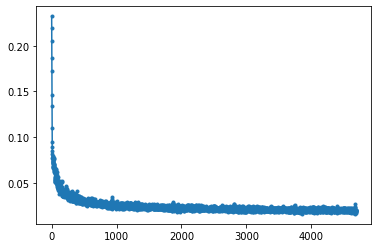

In [4]:
# ==================== Train ==================== #

training_losses = []
for i in (t := trange(max_epochs, ncols= 100)):
    for images, labels in train_dl:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Add noise to the images by blacking out pixels
        noisy_images = nn.Dropout(p=noise_level)(images)
        reconstructions = model(noisy_images)

        model.zero_grad()
        loss = criterion(reconstructions, images)
        training_losses.append(loss.item())
        loss.backward()

        optimizer.step()

        t.set_description(f'Training loss: {loss.item():.4f}')

plt.plot(training_losses, '.-'); plt.show()

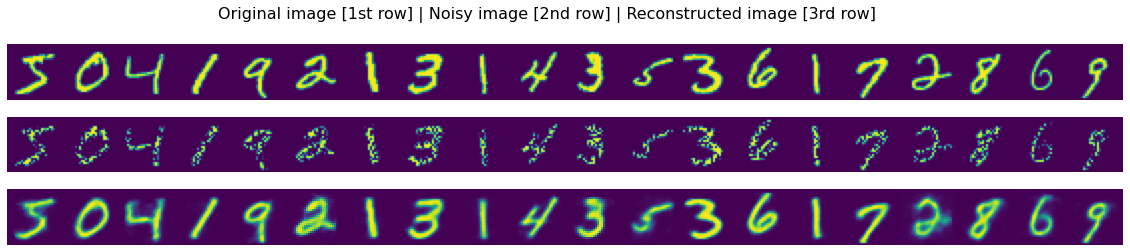

In [12]:
# ==================== Check results ==================== #

model = model.to('cpu')

batch_index = 0
number_of_images = 20
images = next(iter(train_dl))[batch_index][0:number_of_images]

# Original image
fig, axis = plt.subplots(3, number_of_images, figsize=(20, 4))
for index, image in enumerate(images):
    axis[0, index].imshow(image.permute(1, 2, 0))
    axis[0, index].set_axis_off()
    axis[0, index].set_aspect('equal', 'box')
plt.subplots_adjust(wspace=0, hspace=0)

# Reconstruction
with torch.no_grad():
    images = next(iter(train_dl))[0][0:number_of_images]
    noisy_images = nn.Dropout(p=0.50)(images.reshape(-1, 28*28))
    for index, img in enumerate(noisy_images):
        reconstructed_image = model(img)
        axis[1, index].imshow(noisy_images[index].reshape(28,28,1))
        axis[2, index].imshow(reconstructed_image.reshape(28, 28, 1))
        axis[1, index].set_axis_off()
        axis[2, index].set_axis_off()
        axis[1, index].set_aspect('equal', 'box')
        axis[2, index].set_aspect('equal', 'box')
fig.suptitle('Original image [1st row] | Noisy image [2nd row] | Reconstructed image [3rd row]', fontsize=16)
plt.show()